In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import random
import json
import segmentation_models as sm
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#PART 2
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [11]:
dire = "Dataset"

In [5]:
image_patch_size = 256

In [10]:
image_dataset = []
mask_dataset = []
for tile_id in range(1,7):
    for image_id in range(1,20):
        image = cv2.imread(f'{dire}/Tile {tile_id}/images/image_part_00{image_id}.jpg',1)
        mask = cv2.imread(f'{dire}/Tile {tile_id}/masks/image_part_00{image_id}.png',1)

        if image is not None:

            size_x = (image.shape[1]//image_patch_size)*image_patch_size
            size_y = (image.shape[0]//image_patch_size)*image_patch_size

            image = Image.fromarray(image)
            image = image.crop((0,0,size_x,size_y))
            image = np.array(image)
            patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)

            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_image = patched_images[i,j,:,:]

                    individual_image = MinMaxScaler().fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)
                    individual_image = individual_image[0]

                    image_dataset.append(individual_image)

            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, size_x, size_y))
            mask = np.array(mask)
            patched_masks = patchify(mask, (image_patch_size, image_patch_size, 3), step=image_patch_size)

            for i in range(patched_masks.shape[0]):
                for j in range(patched_masks.shape[1]):

                    individual_mask = patched_masks[i, j, :, :]
                    #individual_mask = MinMaxScaler().fit_transform(individual_mask.reshape(-1, individual_mask.shape[-1])).reshape(individual_mask.shape)
                    individual_mask = individual_mask[0]

                    mask_dataset.append(individual_mask)



In [9]:
print(len(image_dataset))
print(len(mask_dataset))

0
0


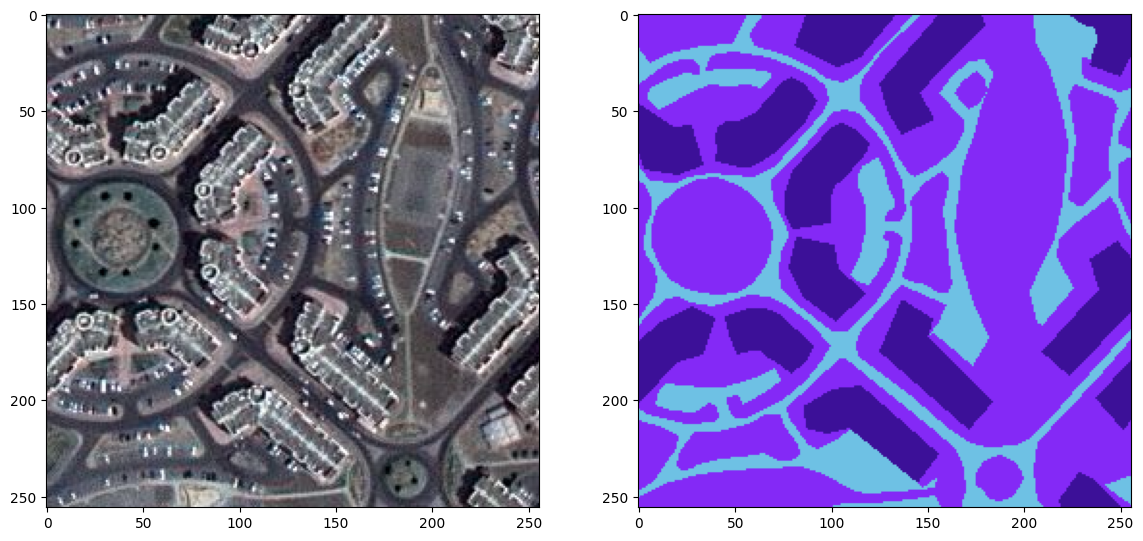

In [13]:
random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])


In [14]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [15]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [16]:
mask_dataset_np = np.array(mask_dataset)
image_dataset_np = np.array(image_dataset)
labels = []
for i in range(mask_dataset_np.shape[0]):
  label = rgb_to_label(mask_dataset_np[i])
  labels.append(label)

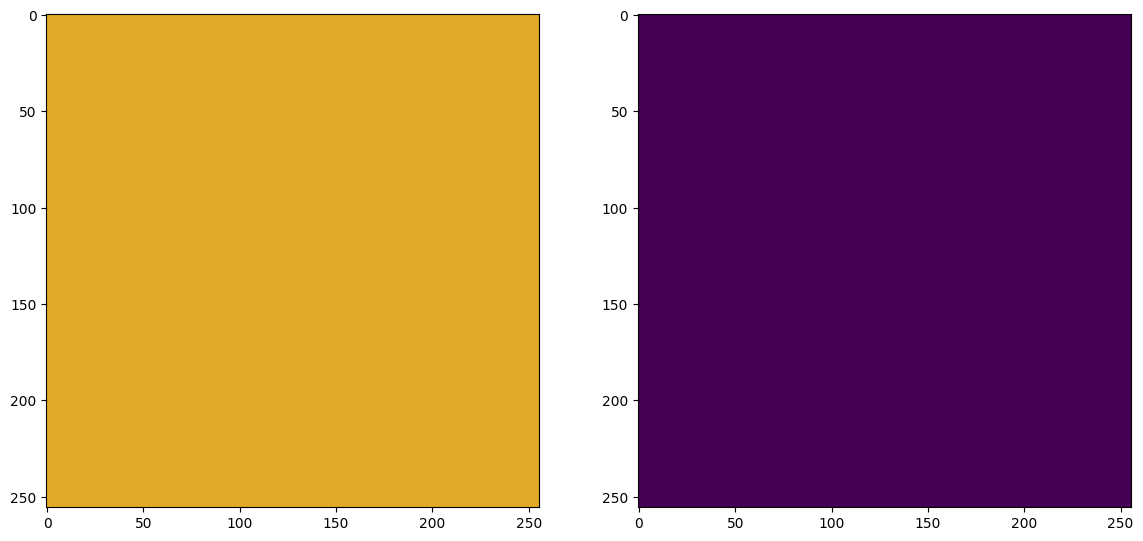

In [17]:
#np.expand_dims(labels,axis=3)

random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(mask_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id])


In [18]:
total_classes = 6

In [19]:
#One hot encoded dataset
#For each pixel its label is represented as an array ex 3 is [0 0 1 0 0 0]
# 5 is [0 0 0 0 1 0]
labels_catagorical_dataset = to_categorical(labels,num_classes = total_classes)

In [20]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset_np,labels_catagorical_dataset,test_size=0.2,random_state=100)

In [21]:
def jaccard_coef(y_true,y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat*y_pred_flat)
    final_coef_value = (intersection +1.0)/(tf.keras.backend.sum(y_true_flat)+tf.keras.backend.sum(y_pred_flat)-intersection+1.0)
    return final_coef_value

In [22]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def R_CNN_model(num_classes, image_height=256, image_width=256, image_channels=3):
    inputs = Input((image_height, image_width, image_channels))

    # Encoding path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoding path
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create and compile the R-CNN model
model = R_CNN_model(6, 256, 256, 3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 256, 256,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     18,464 │ concatenate_2[0]

 Total params: 948,166 (3.62 MB)

 Trainable params: 948,166 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
model_history = model.fit(X_train, y_train, batch_size=16, verbose=1, epochs=250, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2891 - loss: 1.6711 - val_accuracy: 0.3518 - val_loss: 1.4472
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3693 - loss: 1.4301 - val_accuracy: 0.5353 - val_loss: 1.3255
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5570 - loss: 1.2288 - val_accuracy: 0.6447 - val_loss: 0.9449
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6229 - loss: 1.0035 - val_accuracy: 0.6459 - val_loss: 0.9584
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6384 - loss: 0.9363 - val_accuracy: 0.6897 - val_loss: 0.8496
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6659 - loss: 0.9001 - val_accuracy: 0.6797 - val_loss: 0.8538
Epoch 7/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6756 - loss: 0.8636 - val_accuracy: 0.7053 - val_loss: 0.8444
Epoch 8/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6877 - loss: 0.8565 - val_accuracy: 0.7081 - v

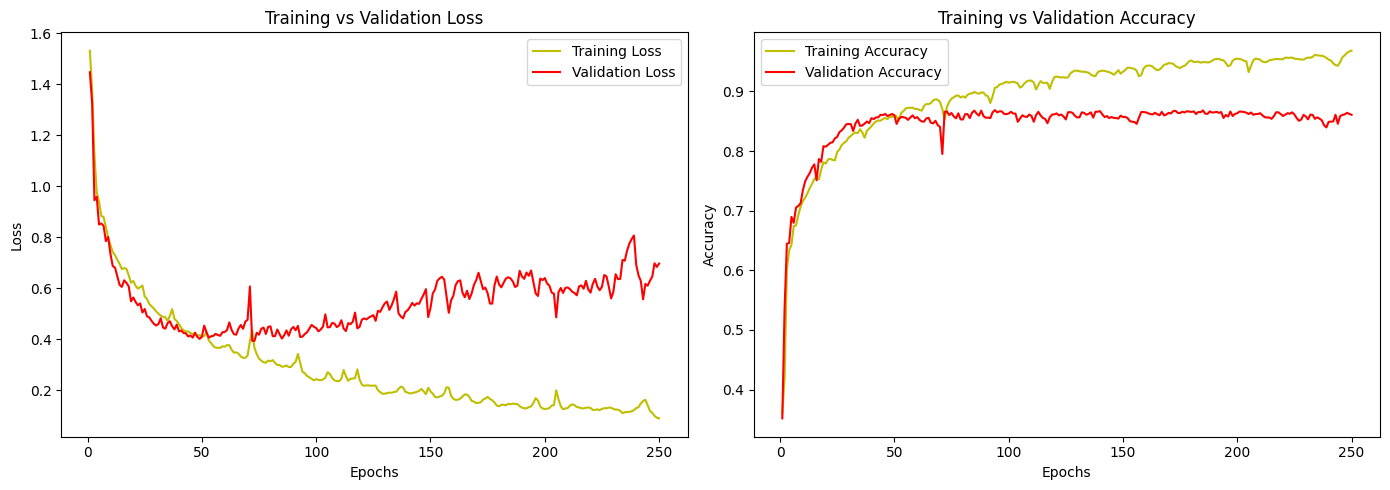

In [24]:
# Plot training and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluation on test data
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 854ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


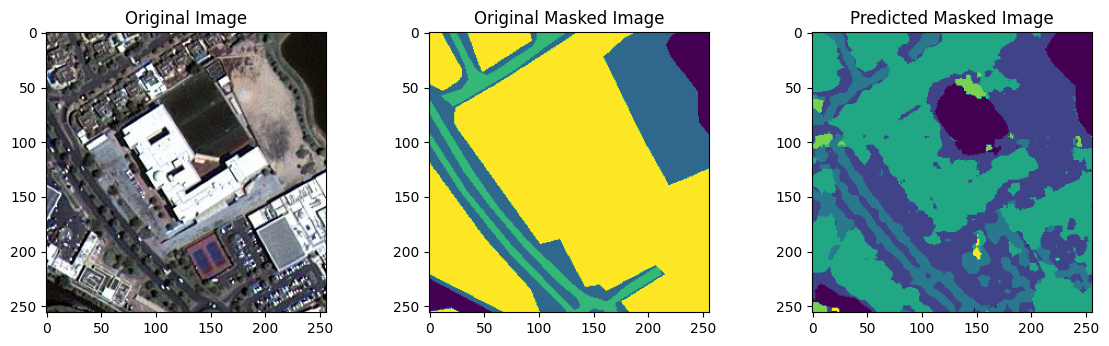

In [26]:
# Comparing Results
test_image_number = random.randint(0, len(y_pred_label))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]

plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)

plt.subplot(232)
plt.title('Original Masked Image')
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title('Predicted Masked Image')
plt.imshow(predicted_image)
plt.show()

In [27]:
type(predicted_image)

numpy.ndarray

In [28]:
model.save("R-CNN_250.h5")